In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import numpy as np
import sys; sys.path.insert(0, '../')
from exp import nb_d2l_utils
%matplotlib inline

In [2]:
#export
import torch
from torch import nn
from functools import partial

In [3]:
torch.__version__

'1.3.1'

In [4]:
X = torch.tensor([1.,2.,3.])
W = torch.randn((3,1), requires_grad=True)

In [5]:
output = X@W
output.backward()
W.grad

tensor([[1.],
        [2.],
        [3.]])

### Hook for tensor

In [6]:
X = torch.tensor([1.,2.,3.])
W = torch.randn((3,1), requires_grad=True)
h0 = W.register_hook(lambda x: 2*x)
h1 = W.register_hook(lambda x: print(x))

In [7]:
output = X@W
output.backward()
h0.remove()
h1.remove()

tensor([[2.],
        [4.],
        [6.]])


### Hook for module

In [8]:
from exp.callback import *

In [9]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.randn((100, 1, 16, 16)), torch.randint(10, (100,))), batch_size=8, shuffle=True)
vali_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.randn((100, 1, 16, 16)), torch.randint(10, (100,))), batch_size=8)

In [10]:
model = nn.Sequential(
    nn.Conv2d(1, 16, 3, stride=2, padding=1),
    nn.Conv2d(16, 8, 3, stride=2, padding=1),
    nn.Flatten(),
    nn.Linear(128, 16),
    nn.ReLU(),
    nn.Linear(16, 10),
)

x = torch.randn((10,1,16,16))
model(x).shape

torch.Size([10, 10])

In [11]:
learn = Learner(
    model=model,
    opt=torch.optim.Adam(model.parameters(), lr=1e-2),
    loss_func=nn.CrossEntropyLoss(),
    data=namedtuple('data', ['train_dl', 'valid_dl'])(train_loader, vali_loader),
)

runner = Runner(cb_funcs=[
    partial(AvgStatsCallback, None),
    partial(BatchTransformXCallback, lambda x: x.view(-1,1,16,16))
])
#runner.fit(10, learn)

In [12]:
#export
class ForwardHook():
    def __init__(self, m, f):
        self.m = m
        self.hook = m.register_forward_hook(partial(f, self))
    @property
    def module(self): return self.m
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

        
class Hooks:
    def __init__(self, modules, hook_fn): 
        self.handlers = []
        for m in modules:
            self.handlers.append(ForwardHook(m, hook_fn))

    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
    def __iter__(self): return iter(self.handlers)
    def __getitem__(self, idx):
        if isinstance(idx, slice): return self.handlers[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def remove(self):
        for h in self.handlers:
            h.remove()

In [13]:
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Flatten()
  (3): Linear(in_features=128, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=10, bias=True)
)

In [14]:
#export
def get_hist(stats):
    return torch.stack(stats).T.float().log1p()

def get_min(stats):
    h1 = torch.stack(stats).t().float()
    return h1[:2].sum(0)/h1.sum(0)

In [15]:
#export
def hook_stats(h, module, input, output):
    if not hasattr(h,'hook_stats'): h.hook_stats = ([],[],[])
    means,stds,hists = h.hook_stats
    means.append(output.data.mean())
    stds .append(output.data.std())
    hists.append(output.data.cpu().histc(80,0,10))

epoch 1: train: 2.29098404 valid: 2.46687286 0.2 sec
epoch 2: train: 1.72414261 valid: 2.97202515 0.1 sec
epoch 3: train: 0.85232140 valid: 4.47560852 0.1 sec


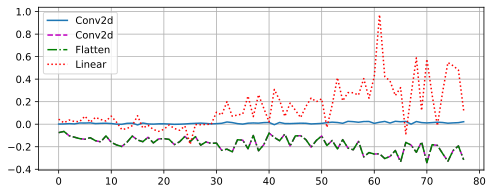

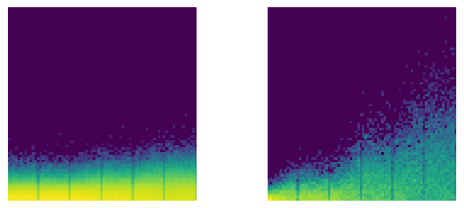

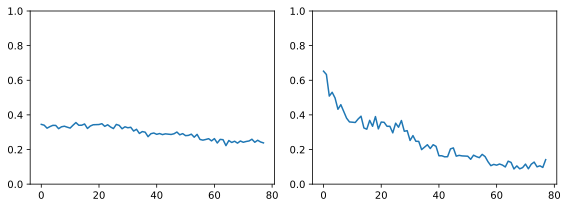

In [16]:
with Hooks(model, hook_stats) as hooks:
    learn = Learner(
        model=model,
        opt=torch.optim.Adam(model.parameters(), lr=1e-2),
        loss_func=nn.CrossEntropyLoss(),
        data=namedtuple('data', ['train_dl', 'valid_dl'])(train_loader, vali_loader),
    )

    runner = Runner(cb_funcs=[
        partial(AvgStatsCallback, None),
        partial(BatchTransformXCallback, lambda x: x.view(-1,1,16,16))
    ])
    
    runner.fit(3, learn)
    
    figsize = (8, 3)
    legends = []
    X = []
    legends = []
    X = []
    for h in hooks:
        if hasattr(h, 'hook_stats'):
            legends.append(h.module._get_name())
            X.append([i.item() for i in h.hook_stats[0]])
    nb_d2l_utils.plot(list(range(len(X[0]))), X, legend=legends, figsize=figsize)
    
    for h in hooks:
        if hasattr(h, 'hook_stats'):
            legends.append(h.module._get_name())
            X.append([i.item() for i in h.hook_stats[1]])
    nb_d2l_utils.plot(list(range(len(X[0]))), X, legend=legends, figsize=figsize)
    
    plt = nb_d2l_utils.plt
    fig, axes = plt.subplots(1,2, figsize=figsize)
    for ax,h in zip(axes.flatten(), hooks[:2]):
        ax.imshow(get_hist(h.hook_stats[2]), origin='lower')
        ax.axis('off')
    plt.tight_layout()
    
    fig,axes = plt.subplots(1,2, figsize=figsize)
    for ax,h in zip(axes.flatten(), hooks[:2]):
        ax.plot(get_min(h.hook_stats[2]))
        ax.set_ylim(0,1)
    plt.tight_layout()

In [17]:
!python notebook2script.py [Advanced]\ Hook.ipynb hook.py
!ls exp

import sys; sys.path.insert(0, '../')
from exp import hook

dir(hook)

Converted [Advanced] Hook.ipynb to exp/hook.py
__init__.py     __pycache__     callback.py     hook.py         nb_d2l_utils.py


['ForwardHook',
 'Hooks',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'get_hist',
 'get_min',
 'hook_stats',
 'nn',
 'partial',
 'torch']

In [18]:
torch.group_norm??

Docstring: <no docstring>
Type:      builtin_function_or_method
